# Base Neural Network Model Training

This notebook builds the foundational neural network model for predicting soft magnetic material properties. The model is trained on a large, comprehensive dataset sourced from literature.

**Objective:**
To train a robust neural network that learns the fundamental composition-property relationships from a broad dataset. This saved model will serve as the **pre-trained base model** for our subsequent transfer learning (TL) task.

**Features (X):**
* **15** Elemental Composition Columns
* **23** `WenAlloys` Physical Features

**Targets (Y):**
The model will be trained to predict 5 key soft magnetic properties. Note that some targets are log-transformed to normalize their distribution, which improves model training.
1.  `Ms` (Saturation Magnetization)
2.  `logHc` (Log of Coercivity)
3.  `logTc` (Log of Curie Temperature)
4.  `logER` (Log of Electrical Resistivity)
5.  `logHV` (Log of Hardness)
6.  `logCost` (Log of Material Cost)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,CSVLogger,LearningRateScheduler
from tensorflow.keras.layers import Input,Dense

## Load Data and Define Features (X) and Targets (Y)

In [2]:
df = pd.read_csv('data/FeNiCo_comp_prop_imp_wen_features.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fe                                1208 non-null   float64
 1   Co                                1208 non-null   float64
 2   Ni                                1208 non-null   float64
 3   V                                 1208 non-null   float64
 4   Mo                                1208 non-null   float64
 5   Cr                                1208 non-null   float64
 6   Cu                                1208 non-null   float64
 7   Mn                                1208 non-null   float64
 8   C                                 1208 non-null   float64
 9   W                                 1208 non-null   float64
 10  Ta                                1208 non-null   float64
 11  Nb                                1208 non-null   float64
 12  Al    

In [3]:
X = df.iloc[:,:-7]
Y = pd.concat([df.iloc[:,-7:-3],df.iloc[:,-2:]], axis=1)
print(f"X shape (features): {X.shape}")
print(f"Y shape (targets): {Y.shape}")

X shape (features): (1208, 38)
Y shape (targets): (1208, 6)


## Scale Data and Create Train/Test Split

We scale X and Y independently using `StandardScaler`. We **must** save the scalers so we can use them for inference later.

In [4]:
# Split data first
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale Y
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"Y_train shape: {Y_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"Y_test shape: {Y_test_scaled.shape}")

X_train shape: (966, 38)
Y_train shape: (966, 6)
X_test shape: (242, 38)
Y_test shape: (242, 6)


In [5]:
# Define the path for saving base model artifacts
ARTIFACT_DIR = 'base_model_artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print(f"Artifacts will be saved to: {ARTIFACT_DIR}")

Artifacts will be saved to: base_model_artifacts


In [6]:
# Save the scalers
joblib.dump(scaler_X, os.path.join(ARTIFACT_DIR, 'scaler_X_base.joblib'))
print(f"Saved base X-scaler to {os.path.join(ARTIFACT_DIR, 'scaler_X_base.joblib')}")
joblib.dump(scaler_Y, os.path.join(ARTIFACT_DIR, 'scaler_Y_base.joblib'))
print(f"Saved base Y-scaler to {os.path.join(ARTIFACT_DIR, 'scaler_Y_base.joblib')}")

Saved base X-scaler to base_model_artifacts\scaler_X_base.joblib
Saved base Y-scaler to base_model_artifacts\scaler_Y_base.joblib


## Building the Neural Network Model

This section defines the architecture for our base model. We will use a deep feed-forward neural network (FNN) to capture the complex, non-linear relationships between the input features (compositions + WenAlloys) and the 5 target properties.

The architecture is designed to be a robust feature extractor, making it a strong candidate for transfer learning later.

**Model Architecture:**
* **Input Layer:** `(None, 38)` (15 composition features + 23 WenAlloys features)
* **Hidden Layer 1:** `Dense(256)` with `relu` activation
* **Hidden Layer 2:** `Dense(128)` with `relu` activation
* **Hidden Layer 3:** `Dense(64)` with `relu` activation
* **Hidden Layer 4:** `Dense(32)` with `relu` activation
* **Output Layer:** `Dense(5)` with `linear` activation (one node for each target: `Ms`, `logHc`, `logTc`, `logER`, `logHV`)

We will compile the model with an `Adam` optimizer and `mae` (Mean Absolute Error) as the loss function, which is a robust choice for regression tasks.

In [7]:
def build_model(input_shape, output_shape):
    """Builds the 4-hidden-layer NNR model."""
    K.clear_session()
    
    inputs = tf.keras.layers.Input(shape=(input_shape,))
    
    # Building network from your code
    hd0 = Dense(256, activation='relu')(inputs)
    hd1 = Dense(128, activation='relu')(hd0)
    hd2 = Dense(64, activation='relu')(hd1)
    hd3 = Dense(32, activation='relu')(hd2)
    outputs = Dense(output_shape, activation='linear')(hd3)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    # Compiling with 'mae' loss as you had
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='mae', 
                  metrics=['mean_squared_error']) # We can still track MSE
    return model

input_dim = X_train_scaled.shape[1]
output_dim = Y_train_scaled.shape[1]

model = build_model(input_dim, output_dim)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 256)               9984      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 6)                 198       
                                                                 
Total params: 53,414
Trainable params: 53,414
Non-trainable p

## Training the Base Model

With the model architecture defined and compiled, we now train it on our processed data.

We will train for **128 epochs** using a **batch size of 32**. The `X_train_scaled` and `Y_train_scaled` data is used for training, and we will validate our model's performance on the unseen `X_test_scaled` and `Y_test_scaled` data at the end of each epoch.

To manage the training process, we are using the following callbacks:
* **`CSVLogger`**: Saves the training and validation loss from every epoch to `base_model_artifacts/training_log_base.csv`.
* **`ReduceLROnPlateau`**: Monitors the `val_loss` and reduces the learning rate by a factor of 0.5 if it stops improving for 4 epochs.

In [8]:
# 1. CSVLogger to save epoch logs
log_path = os.path.join(ARTIFACT_DIR, 'training_log_base.csv')
csv_logger = CSVLogger(log_path)

# 2. ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=4e-5)

# --- Model Training ---
print("Starting model training with custom callbacks...")

# We use the scaled data (X_train_scaled, Y_train_scaled) for training
# and the scaled test data for validation.
history = model.fit(
    X_train_scaled, Y_train_scaled,
    batch_size=32,
    shuffle=True,
    callbacks=[csv_logger, reduce_lr],
    epochs=128,
    validation_data=(X_test_scaled, Y_test_scaled),
    initial_epoch=0
)

print("Model training complete.")
print(f"Training log saved to {log_path}")

Starting model training with custom callbacks...
Epoch 1/128
31/31 [==============================] - 2s 10ms/step - loss: 0.8370 - mean_squared_error: 1.1655 - val_loss: 0.7740 - val_mean_squared_error: 0.9630 - lr: 1.0000e-04
Epoch 2/128
31/31 [==============================] - 0s 6ms/step - loss: 0.7386 - mean_squared_error: 0.9055 - val_loss: 0.7144 - val_mean_squared_error: 0.8484 - lr: 1.0000e-04
Epoch 3/128
31/31 [==============================] - 0s 6ms/step - loss: 0.6775 - mean_squared_error: 0.7951 - val_loss: 0.6625 - val_mean_squared_error: 0.7658 - lr: 1.0000e-04
Epoch 4/128
31/31 [==============================] - 0s 7ms/step - loss: 0.6186 - mean_squared_error: 0.7007 - val_loss: 0.6066 - val_mean_squared_error: 0.6739 - lr: 1.0000e-04
Epoch 5/128
31/31 [==============================] - 0s 6ms/step - loss: 0.5540 - mean_squared_error: 0.6002 - val_loss: 0.5416 - val_mean_squared_error: 0.5762 - lr: 1.0000e-04
Epoch 6/128
31/31 [==============================] - 0s 6ms/

## Plot and Save Training History

Saved training history plot to 'base_model_artifacts\base_model_training_history.jpg'


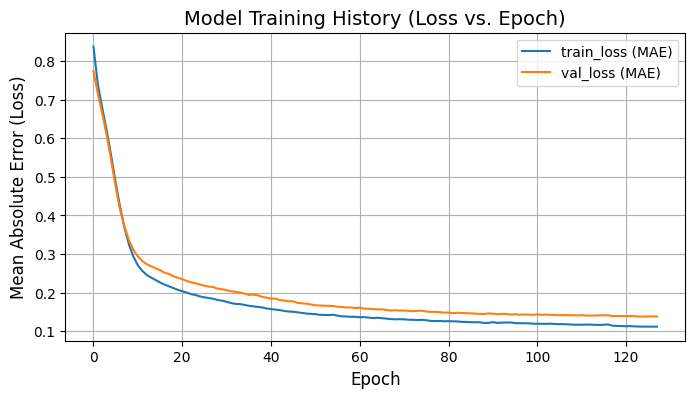

In [9]:
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(8, 4))
plt.plot(hist_df['loss'], label='train_loss (MAE)')
plt.plot(hist_df['val_loss'], label='val_loss (MAE)')
plt.title('Model Training History (Loss vs. Epoch)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Absolute Error (Loss)', fontsize=12)
plt.legend()
plt.grid(True)
history_plot_path = os.path.join(ARTIFACT_DIR, 'base_model_training_history.jpg')
plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')
print(f"Saved training history plot to '{history_plot_path}'")
plt.show()

## Evaluate Model and Save Parity Plots

Now that the model is trained, we will evaluate its performance. This involves:
1.  Using the trained model to make predictions on both the training and test sets.
2.  Inverse-transforming the predictions (which are scaled) back to their original units (e.g., `logHc`, `Ms`). We must also use the unscaled, original `Y_train` and `Y_test` for a fair comparison.
3.  Calculating R², MAE, and RMSE metrics for each of the 5 targets.
4.  Generating and saving "parity plots" (Actual vs. Predicted) for each target, which give a clear visual assessment of the model's accuracy.

In [10]:
def plot_parity_plots(y_train, y_pred_train, y_test, y_pred_test, target_names, target_labels, metrics_df):
    """
    Creates a grid of parity plots (Actual vs. Predicted) for
    train and test sets for each target variable.
    Saves the plot to the ARTIFACT_DIR.
    """
    #  --- Convert inputs to NumPy arrays for slicing ---
    # This handles the case where a pandas DataFrame is passed.
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values
    
    n_targets = len(target_names)
    
    fig, axes = plt.subplots(n_targets, 2, figsize=(10, n_targets * 5))
    
    if n_targets == 1:
        axes = np.array([axes])

    for i in range(n_targets):
        target_name = target_names[i]
        target_label = target_labels[i] 
        
        # --- Training Set Plot (Column 0) ---
        ax_train = axes[i, 0]
        # This [:, i] slicing is why we need NumPy arrays
        ax_train.scatter(y_train[:, i], y_pred_train[:, i], color='#4A70A9', alpha=0.8, s=25) 
        
        lims = [
            np.min([ax_train.get_xlim(), ax_train.get_ylim()]),
            np.max([ax_train.get_xlim(), ax_train.get_ylim()]),
        ]
        ax_train.plot(lims, lims, 'k--', lw=1.5)
        ax_train.set_xlabel('Actual Value', fontsize=14)
        ax_train.set_ylabel('Predicted Value', fontsize=14)
        ax_train.set_title(f'Train Set - {target_label}', fontsize=16)
        ax_train.tick_params(axis='both', which='major', labelsize=11)
        
        # --- Add metrics text to train plot ---
        r2_train = metrics_df.loc[(target_name, 'Train')]['R2']
        mae_train = metrics_df.loc[(target_name, 'Train')]['MAE']
        mse_train = metrics_df.loc[(target_name, 'Train')]['RMSE']
        metrics_text_train = (
            f"$R^2$: {r2_train:.3f}\n"
            f"MAE: {mae_train:.3f}\n"
            f"RMSE: {mse_train:.3f}"
        )
        ax_train.text(0.05, 0.95, metrics_text_train, transform=ax_train.transAxes, 
                        fontsize=12, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # --- Test Set Plot (Column 1) ---
        ax_test = axes[i, 1]
        # This [:, i] slicing is why we need NumPy arrays
        ax_test.scatter(y_test[:, i], y_pred_test[:, i], color='#B77466', alpha=0.8, s=25) 
        
        lims = [
            np.min([ax_test.get_xlim(), ax_test.get_ylim()]),
            np.max([ax_test.get_xlim(), ax_test.get_ylim()]),
        ]
        ax_test.plot(lims, lims, 'k--', lw=1.5)
        ax_test.set_xlabel('Actual Value', fontsize=14)
        ax_test.set_ylabel('Predicted Value', fontsize=14)
        ax_test.set_title(f'Test Set - {target_label}', fontsize=16)
        ax_test.tick_params(axis='both', which='major', labelsize=11)

        # --- Add metrics text to test plot ---
        r2_test = metrics_df.loc[(target_name, 'Test')]['R2']
        mae_test = metrics_df.loc[(target_name, 'Test')]['MAE']
        mse_test = metrics_df.loc[(target_name, 'Test')]['RMSE']
        metrics_text_test = (
            f"$R^2$: {r2_test:.3f}\n"
            f"MAE: {mae_test:.3f}\n"
            f"RMSE: {mse_test:.3f}"
        )
        ax_test.text(0.05, 0.95, metrics_text_test, transform=ax_test.transAxes, 
                       fontsize=12, verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
    plt.tight_layout()
    
    # Save to the artifact directory
    plot_save_path = os.path.join(ARTIFACT_DIR, 'base_model_parity_plots.png')
    plt.savefig(plot_save_path)
    print(f"\nSaved parity plots to '{plot_save_path}'")
    plt.show()

In [11]:
# List of target names (matching the DataFrame columns)
TARGET_NAMES = ['Ms', 'logHc', 'logTc', 'logER', 'logHV', 'logCost']

# List of "pretty" labels (using LaTeX) for the plot titles
TARGET_LABELS = [
    r'$M_s$', 
    r'$log_{10}(H_c)$', 
    r'$log_{10}(T_c)$', 
    r'$log_{10}(\rho)$', 
    r'$log_{10}(H_V)$',
    r'$log_{10}(Cost)$'
]


--- Evaluating Model Performance ---
8/8 [==============================] - 0s 2ms/step
                  R2    MAE   RMSE
Target  Set                       
Ms      Train  0.978  0.033  0.079
        Test   0.968  0.043  0.090
logHc   Train  0.859  0.182  0.348
        Test   0.851  0.214  0.372
logTc   Train  0.970  0.005  0.020
        Test   0.978  0.006  0.017
logER   Train  0.777  0.051  0.124
        Test   0.702  0.069  0.143
logHV   Train  0.814  0.030  0.078
        Test   0.749  0.033  0.083
logCost Train  1.000  0.003  0.007
        Test   0.997  0.006  0.021

Saved parity plots to 'base_model_artifacts\base_model_parity_plots.png'


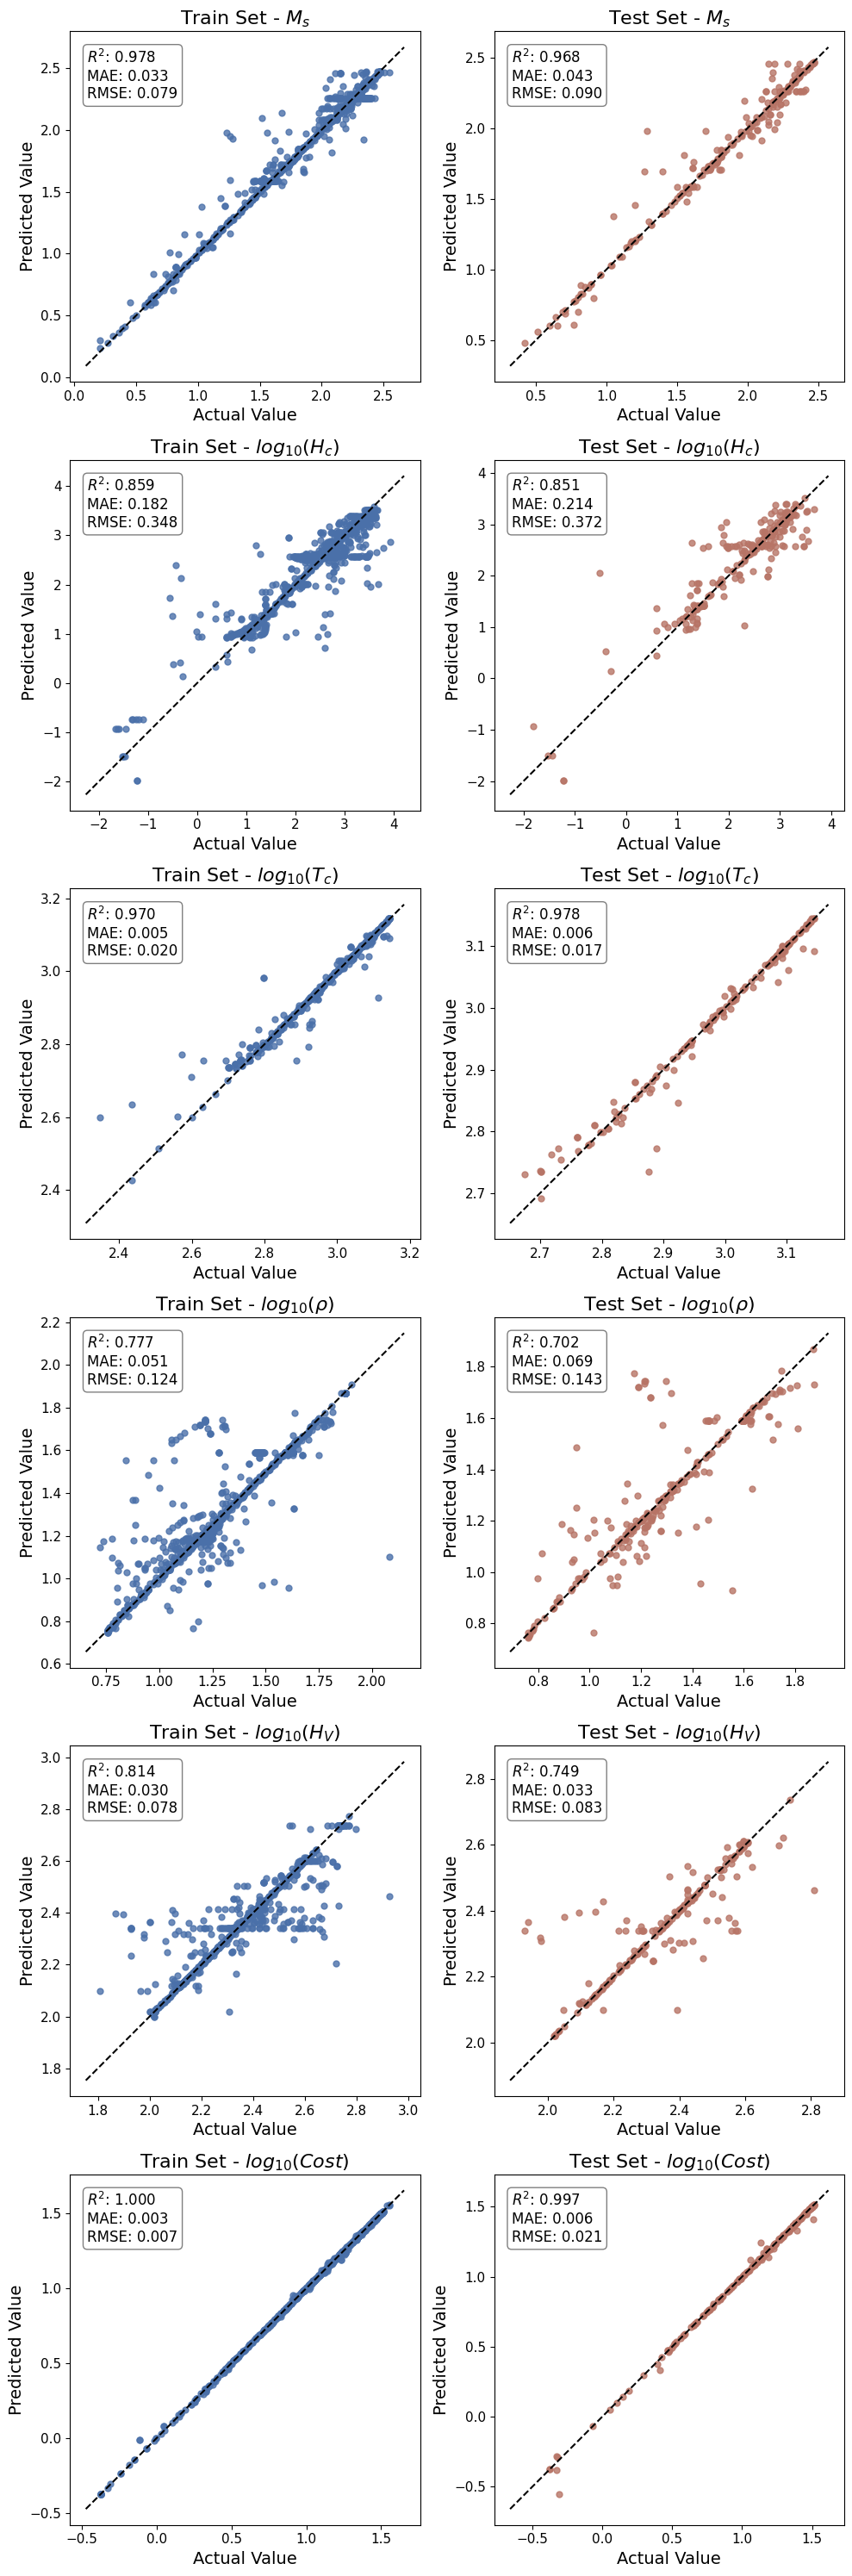

In [12]:
print("\n--- Evaluating Model Performance ---")

# 1. Predict on scaled data
y_pred_train_scaled = model.predict(X_train_scaled)
y_pred_test_scaled = model.predict(X_test_scaled)

# 2. Inverse-transform to original scale
#    We use the scaler_Y that we saved earlier
y_pred_train = scaler_Y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_Y.inverse_transform(y_pred_test_scaled)

#    Get the original, unscaled target values
y_train_actual = Y_train 
y_test_actual = Y_test

# Ensure we are using NumPy arrays for slicing
if isinstance(y_train_actual, pd.DataFrame):
    y_train_actual_np = y_train_actual.values
else:
    y_train_actual_np = y_train_actual

if isinstance(y_test_actual, pd.DataFrame):
    y_test_actual_np = y_test_actual.values
else:
    y_test_actual_np = y_test_actual   

# 3. Calculate and display metrics
metrics_data = {'Target': [], 'Set': [], 'R2': [], 'MAE': [], 'RMSE': []}

for i, name in enumerate(TARGET_NAMES):
    # Train metrics
    metrics_data['Target'].append(name)
    metrics_data['Set'].append('Train')
    metrics_data['R2'].append(r2_score(y_train_actual_np[:, i], y_pred_train[:, i]))
    metrics_data['MAE'].append(mean_absolute_error(y_train_actual_np[:, i], y_pred_train[:, i]))
    metrics_data['RMSE'].append(np.sqrt(mean_squared_error(y_train_actual_np[:, i], y_pred_train[:, i])))
    
    # Test metrics
    metrics_data['Target'].append(name)
    metrics_data['Set'].append('Test')
    metrics_data['R2'].append(r2_score(y_test_actual_np[:, i], y_pred_test[:, i]))
    metrics_data['MAE'].append(mean_absolute_error(y_test_actual_np[:, i], y_pred_test[:, i]))
    metrics_data['RMSE'].append(np.sqrt(mean_squared_error(y_test_actual_np[:, i], y_pred_test[:, i])))

# Display metrics in a clean DataFrame
metrics_df = pd.DataFrame(metrics_data).set_index(['Target', 'Set'])
print(metrics_df.round(3))

# 4. Call the plotting function
plot_parity_plots(
    y_train_actual, 
    y_pred_train, 
    y_test_actual, 
    y_pred_test, 
    TARGET_NAMES,
    TARGET_LABELS,
    metrics_df
)

## Save the Metrics DataFrame and Final Model

In [13]:
model_save_path = os.path.join(ARTIFACT_DIR, 'base_nn_model.keras')
model.save(model_save_path)
print(f"\nSaved Keras base model to '{model_save_path}'")


Saved Keras base model to 'base_model_artifacts\base_nn_model.keras'


In [14]:
metrics_save_path = os.path.join(ARTIFACT_DIR, 'base_model_metrics.csv')
metrics_df.to_csv(metrics_save_path)
print(f"\nSaved metrics to '{metrics_save_path}'")


Saved metrics to 'base_model_artifacts\base_model_metrics.csv'
